# Object Detection with Faster RCNN

---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
!pip install torch
!pip install torchvision

In [3]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [4]:
print(torch.__version__)
print(torchvision.__version__)

1.9.1
0.10.1


In [14]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373906 sha256=df28bded63c4ecc35ce22dbfa684e93b45786c1cbcb44ffbbcf2ff81b1708bfa
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


In [5]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [6]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WKXWbCvU2Cj4xjlBSJbA")
project = rf.workspace("abdellateef-eid").project("best_pistol_knife_dataset")
dataset = project.version(4).download("coco")

     |████████████████████████████████| 57 kB 3.3 MB/s             
     |████████████████████████████████| 58 kB 5.7 MB/s             
     |████████████████████████████████| 67 kB 5.6 MB/s             
     |████████████████████████████████| 54 kB 2.7 MB/s             
     |████████████████████████████████| 155 kB 50.0 MB/s            
     |████████████████████████████████| 55 kB 2.5 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 15.7 MB 48.6 MB/s            
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=2840f0283f0a6c485a49d18813f360f07acd0ef2ef848c319437d4ffa49abc2e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.6
    Uninstalling pyparsing-3.0.6:
      Successfully uninstalled pyparsing-3.0.6
  Attempting uninstall: numpy
    Found ex

Extracting Dataset Version Zip to best_pistol_knife_dataset-4 in coco:: 100%|██████████| 5845/5845 [00:01<00:00, 4434.45it/s]


In [9]:
os.rename("best_pistol_knife_dataset-4","guns-knives")

In [11]:
class DatasetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [12]:
dataset_path = "/kaggle/working/guns-knives"

In [15]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{0: {'id': 0, 'name': 'weapon', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'knife', 'supercategory': 'weapon'},
 2: {'id': 2, 'name': 'pistol', 'supercategory': 'weapon'}}

In [16]:
classes = [i[1]['name'] for i in categories.items()]
classes

['weapon', 'knife', 'pistol']

In [18]:
train_dataset = DatasetDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

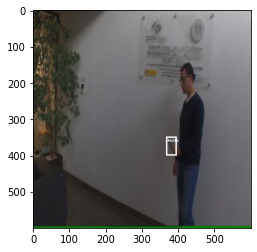

In [20]:
# Lets view a sample
sample = train_dataset[23]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

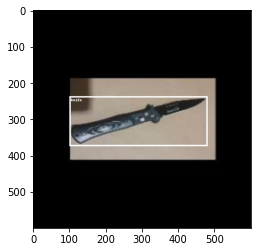

In [21]:
# Lets view a sample
sample = train_dataset[6]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [22]:
len(train_dataset)

4389

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 3 classes but this model was trained on 90 classes.

In [23]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [25]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [26]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [27]:
device = torch.device("cuda") # use GPU to train

In [28]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [29]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [30]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [31]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [32]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 1098/1098 [02:29<00:00,  7.32it/s]


Epoch 0, lr: 0.010000, loss: 0.432140, loss_classifier: 0.179236, loss_box: 0.189300, loss_rpn_box: 0.027481, loss_object: 0.036123


100%|██████████| 1098/1098 [02:17<00:00,  8.01it/s]


Epoch 1, lr: 0.010000, loss: 0.430755, loss_classifier: 0.177110, loss_box: 0.206177, loss_rpn_box: 0.022826, loss_object: 0.024641


100%|██████████| 1098/1098 [02:14<00:00,  8.16it/s]


Epoch 2, lr: 0.010000, loss: 0.440045, loss_classifier: 0.177595, loss_box: 0.221541, loss_rpn_box: 0.020967, loss_object: 0.019942


100%|██████████| 1098/1098 [02:12<00:00,  8.26it/s]


Epoch 3, lr: 0.010000, loss: 0.453134, loss_classifier: 0.181797, loss_box: 0.232812, loss_rpn_box: 0.020194, loss_object: 0.018332


100%|██████████| 1098/1098 [02:13<00:00,  8.20it/s]


Epoch 4, lr: 0.010000, loss: 0.435278, loss_classifier: 0.173103, loss_box: 0.224111, loss_rpn_box: 0.019777, loss_object: 0.018287


100%|██████████| 1098/1098 [02:10<00:00,  8.40it/s]


Epoch 5, lr: 0.010000, loss: 0.449239, loss_classifier: 0.176139, loss_box: 0.238064, loss_rpn_box: 0.018926, loss_object: 0.016110


100%|██████████| 1098/1098 [02:10<00:00,  8.41it/s]


Epoch 6, lr: 0.010000, loss: 0.443640, loss_classifier: 0.173198, loss_box: 0.237039, loss_rpn_box: 0.018260, loss_object: 0.015143


100%|██████████| 1098/1098 [02:09<00:00,  8.46it/s]


Epoch 7, lr: 0.010000, loss: 0.450219, loss_classifier: 0.174795, loss_box: 0.243152, loss_rpn_box: 0.017626, loss_object: 0.014646


100%|██████████| 1098/1098 [02:09<00:00,  8.49it/s]


Epoch 8, lr: 0.010000, loss: 0.445805, loss_classifier: 0.172814, loss_box: 0.240676, loss_rpn_box: 0.017476, loss_object: 0.014839


100%|██████████| 1098/1098 [02:09<00:00,  8.48it/s]

Epoch 9, lr: 0.010000, loss: 0.449148, loss_classifier: 0.172805, loss_box: 0.243361, loss_rpn_box: 0.018357, loss_object: 0.014625


## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [36]:
model.eval()
torch.cuda.empty_cache()

In [37]:
test_dataset = DatasetDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [47]:
img, _ = test_dataset[20]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

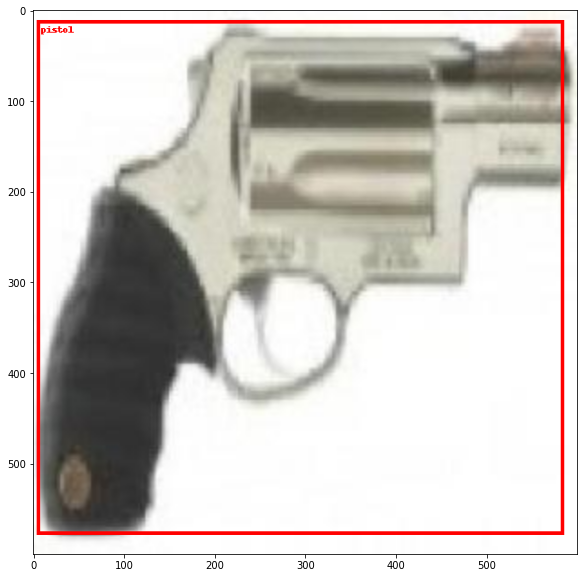

In [48]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4,colors=(255,0,0)
).permute(1, 2, 0))